In [2]:
from google.colab import drive
drive.mount('LeNet-5')

Mounted at LeNet-5


In [3]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [5]:
#정확도 구하는 function과
#손실을 시각화 하는 function 정의
def get_accuracy(model, data_loader, device):
  correct_pred = 0
  n = 0

  with torch.no_grad():
    model.eval()
    for X, y_true in data_loader:

      X = X.to(device)
      y_true = y_true.to(device)

      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob,1)

      n += y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()

  return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):

  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig, ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_losses, color = 'blue', label = 'Training loss')
  ax.plot(valid_losses, color= 'red', label = 'Validation loss')
  ax.set(title = "Loss over epochs", xlabel = 'Epoch', ylabel = 'Loss')
  ax.legend()
  fig.show()

  plt.style.use('default')

In [6]:
#training data에 사용되는 helper 함수 정의하기
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for X, y_true in train_loader:

    optimizer.zero_grad()

    X = X.to(device)
    y_true = y_true.to(device)

    y_hat,_ = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [7]:
#validation data에 사용되는 함수 정의(역전파 진행하지 않음)
def validate(valid_loader, model, criterion, device):

  model.eval()
  running_loss = 0

  for X, y_true in valid_loader:

    X = X.to(device)
    y_true = y_true.to(device)

    y_hat,_ = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)

  return model,epoch_loss

In [8]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every = 1):
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  for epoch in range(0,epochs):
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    if epoch % print_every == (print_every - 1):
      train_acc = get_accuracy(model, train_loader, device = device)
      valid_acc = get_accuracy(model, valid_loader, device = device)

  print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

  plot_losses(train_losses, valid_losses)
    
  return model, optimizer, (train_losses, valid_losses)

In [ ]:
#data 준비
transforms = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

train_dataset= datasets.MNIST(root='mnist_data', train = True, transform = transforms, download = True)

valid_dataset = datasets.MNIST(root = 'mnist_data', train = False, transform = transforms)

train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [11]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [12]:
#model, optimizer, loss function 설정하기
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

03:40:37 --- Epoch: 14	Train loss: 0.0110	Valid loss: 0.0402	Train accuracy: 99.78	Valid accuracy: 98.87


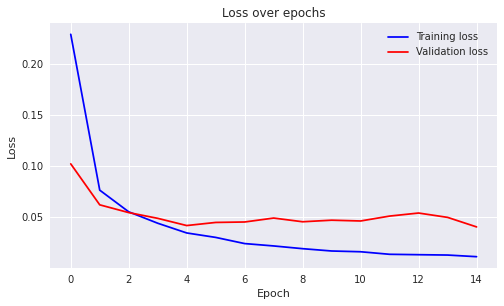

In [13]:
#신경망 학습
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)